# input : (256,256), VGG16 + fine tuning (Block 5 ~) + Dense 3개 drop out O

In [1]:
import os
import numpy as np
import tensorflow as tf

# gpu 문제로 코드가 안돌아가는 상황이 있어서 set_memory_growth 셋팅을 설정해준 코드
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
data_path = "C:\\Users\\Owner6\\workspace\\midterm\\after_data"

train_path = os.path.join(data_path, 'train')
validation_path = os.path.join(data_path, 'validation')
test_path = os.path.join(data_path, 'test')

train_len = len(os.listdir( os.path.join( train_path, 'normal' ) )) +\
    len(os.listdir( os.path.join( train_path, 'bacteria' ) )) +\
    len(os.listdir( os.path.join( train_path, 'virus' ) )) +\
    len(os.listdir( os.path.join( train_path, 'covid' ) ))
    
validation_len = len(os.listdir( os.path.join( validation_path, 'normal' ) )) +\
    len(os.listdir( os.path.join( validation_path, 'bacteria' ) )) +\
    len(os.listdir( os.path.join( validation_path, 'virus' ) )) +\
    len(os.listdir( os.path.join( validation_path, 'covid' ) ))
    
test_len = len(os.listdir( os.path.join( test_path, 'normal' ) )) +\
    len(os.listdir( os.path.join( test_path, 'bacteria' ) )) +\
    len(os.listdir( os.path.join( test_path, 'virus' ) )) +\
    len(os.listdir( os.path.join( test_path, 'covid' ) ))

print(f'train : {train_len}, validation : {validation_len}, test : {test_len}')

train : 11507, validation : 1645, test : 3286


In [3]:
# ImageDataGenerator를 통해 이미지를 원하는 shape으로 불러오고 augmentation 해줄 수 있음
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 0~1 정규화
data_gen = ImageDataGenerator(rescale=1./255)

# flow_from_directory를 통해서 폴더에 분류 있는 데이터들을 레이블과 함께 얻어올 수 있음
train_data = data_gen.flow_from_directory(
    train_path, class_mode='categorical', color_mode='rgb',
    target_size=(256,256), batch_size=37 # 11507 = 37 * 311
)

validation_data = data_gen.flow_from_directory(
    validation_path, class_mode='categorical', color_mode='rgb',
    target_size=(256,256), batch_size=35 # 1645 = 35 * 47
)

test_data = data_gen.flow_from_directory(
    test_path, class_mode='categorical', color_mode='rgb',
    target_size=(256,256), batch_size=31 # 3286 = 31 * 106
)

# train_x, train_y = train_data.next()
# validation_x, validation_y = validation_data.next()
# test_x, test_y = test_data.next()

# train_x.shape, train_y.shape

Found 11507 images belonging to 4 classes.
Found 1645 images belonging to 4 classes.
Found 3286 images belonging to 4 classes.


In [4]:
# VGG16을 불러와 사용
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

In [5]:
# conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [6]:
from tensorflow.keras import models, layers

# VGG16 모델 뒤에 Dense layer 세 개 쌓고 overfitting을 막기 위해 사이 사이에 Dropout layer를 한 개씩 추가
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4, activation='softmax'))

In [7]:
# Fine Tuning 부분 (block5_conv1 layer 부터 trainable하게 바꾸어줌)
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [8]:
# epoch 마다 모델 성능이 나아졌을 때 마다 모델을 저장해주는 콜백 함수
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model/3/{epoch:02d}-{val_accuracy:.5f}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [9]:
model.compile(optimizer="rmsprop", \
    loss='categorical_crossentropy', 
    metrics=['accuracy'])


In [10]:
history = model.fit(train_data, steps_per_epoch=311, epochs=20,\
    validation_data=validation_data, validation_steps=47, callbacks=[model_checkpoint_callback])

Epoch 1/20
311/311 [==============================] - 187s 578ms/step - loss: 2.6357 - accuracy: 0.7608 - val_loss: 0.3598 - val_accuracy: 0.8559

Epoch 00001: val_accuracy improved from -inf to 0.85593, saving model to model/3\01-0.85593.h5
Epoch 2/20
311/311 [==============================] - 177s 569ms/step - loss: 0.3258 - accuracy: 0.8742 - val_loss: 0.3257 - val_accuracy: 0.8663

Epoch 00002: val_accuracy improved from 0.85593 to 0.86626, saving model to model/3\02-0.86626.h5
Epoch 3/20
311/311 [==============================] - 177s 569ms/step - loss: 0.2885 - accuracy: 0.8969 - val_loss: 0.2294 - val_accuracy: 0.9064

Epoch 00003: val_accuracy improved from 0.86626 to 0.90638, saving model to model/3\03-0.90638.h5
Epoch 4/20
311/311 [==============================] - 177s 569ms/step - loss: 0.2790 - accuracy: 0.9104 - val_loss: 0.2218 - val_accuracy: 0.9161

Epoch 00004: val_accuracy improved from 0.90638 to 0.91611, saving model to model/3\04-0.91611.h5
Epoch 5/20
311/311 [===

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

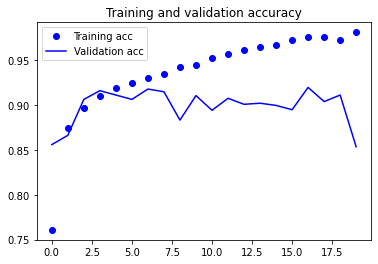

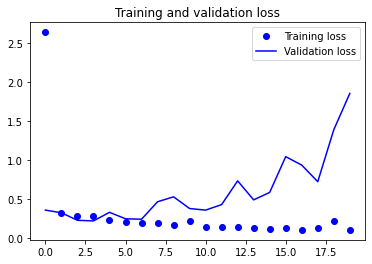

In [12]:
# 학습 과정의 accuracy와 loss 값을 plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.evaluate(test_data, steps=3286 // 31)

106/106 [==============================] - 46s 414ms/step - loss: 1.9548 - accuracy: 0.8576


[1.9548126459121704, 0.8575776219367981]